In [1]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from neuralnetwork.autoencoder import CAE
from neuralnetwork.preprocessing import generate_esn_noise_data, train_valid_test_split

sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers

#### 1: Load the trained CAE and the encoded time series

In [11]:
cae_path = Path('../weights/fluent-sweep-2/')
with open(cae_path/'ks.json') as f:
    ks_data = json.load(f)
print(ks_data)

with open(cae_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)
print(f"Encoded timeseries {U_encoded.shape}")

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.005, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.08}
Encoded timeseries (499751, 8)


#### 2: Prepare the encoded data for the ESN training

In [3]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)

In [4]:
total_samples, dim = u_encoded_train.shape
N_washout = 200
train_size = min(len(u_encoded_train)-N_washout-101, 100000)#-1001
val_size = min(len(u_encoded_valid)-101-N_washout, 20001)
test_N_washout = 100
# Split the data into different datasets
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout:N_washout+train_size-1, ...]
U_train_label = u_encoded_train[N_washout + 1:N_washout+train_size, ...]
U_val_input = u_encoded_valid[:val_size-1, ...]
U_val_label = u_encoded_valid[1:val_size, ...]
U_test_washout = u_encoded_test[:test_N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]
# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape, U_train_label.shape}")
print(f"U_val shape: {U_val_input.shape, U_val_label.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: ((99999, 8), (99999, 8))
U_val shape: ((20000, 8), (20000, 8))
U_test shape: (139551, 8)


#### 3: Validate the hyperparameters of the ESN

In [5]:
#  specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
hyperparameter_dict = {
    'spectral_radius': [0.1, 1.0, 'uniform'],
    'input_scaling': [0.01, 10.0, 'log10'],
    'tikhonov': [1e-12, 1e-3, 'log10'],
    # 'leak_factor': [0.1, 1.0, 'uniform']  # Uncomment if needed
}
grid_range = []
for i, parameter in enumerate(hyperparameter_dict.keys()):
    scaler = getattr(scalers, hyperparameter_dict[parameter][-1])
    grid_range.append(scaler(hyperparameter_dict[parameter][:2]))

# compute normalization factor (range component-wise)
U_data = U_esn[:N_washout+train_size, :dim].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

N_val = 1000  # number of validation steps

# fixed properties of the ESN
ESN_dict = {'reservoir_size': 1000,
        'dimension': dim,
        'reservoir_connectivity': 10,
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]),
        'input_bias': np.array([1]),
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]*2),
        'output_bias':  np.array([1]),
        'reservoir_weights_mode': "erdos_renyi1",
        # 'tikhonov': 1e-10,
        'input_normalization': [u_mean, norm],
        # 'input_weights_mode': 'dense',
        'input_seeds':[0, 1, 2],
        'reservoir_seeds':[3, 4]
    }


min_dict = validate(
    grid_range=grid_range,
    param_names=[key for key in hyperparameter_dict.keys()],
    param_scales=[values[-1] for values in hyperparameter_dict.values()],
    n_calls=20,  # number of total trials
    n_initial_points=10,  # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict,
    U_washout_train=U_washout,
    n_realisations=1,  # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label,
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=5,  # number of folds, i.e., validation time series that start from random time instances
    N_washout_steps=N_washout,
    N_val_steps=N_val,
    random_seed=10,  # random seed for the bayesian optimization
    error_measure=errors.rel_L2)  # error measure to optimize over

esn_loaded_dict = dict(min_dict, **ESN_dict)

Input to run_gp:([Real(low=0.1, high=1.0, prior='uniform', transform='identity'), Real(low=-2.0, high=1.0, prior='uniform', transform='identity'), Integer(low=-12.0, high=-3.0, prior='uniform', transform='identity')], 20, 10, 10)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6335601564025166
input_scaling 3.41033659841376
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  0.9958130021925252
Fold: 1 , fold error:  1.2273407000853556
Fold: 2 , fold error:  1.1477714897908107
Fold: 3 , fold error:  1.203531262122409
Fold: 4 , fold error:  1.097812552223131
Val regime error: 1.1344538012828462
Realisation error: 1.1344538012828462


Run 1 error: 1.1344538012828462


--NEW RUN-- 2
Realisation: 0
spectral_radius 0.8625265649057131
input_scaling 0.7424908231815013
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  1.0998975247946525
Fold: 1 , fold error:  0.9457004045388029
Fold: 2 , fold error:  0.946236678863257
Fold: 3 , fold error:  0.995416999723988

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.67618e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9088393334124882
Fold: 1 , fold error:  0.8686286866780792
Fold: 2 , fold error:  0.9084512845743921
Fold: 3 , fold error:  0.815069906393401
Fold: 4 , fold error:  0.8300155678653135
Val regime error: 0.8662009557847348
Realisation error: 0.8662009557847348


Run 3 error: 0.8662009557847348


--NEW RUN-- 4
Realisation: 0
spectral_radius 0.529898605589215
input_scaling 2.732160361977424
tikhonov 1e-08


Val regime: 0
Fold: 0 , fold error:  1.233771839344706
Fold: 1 , fold error:  0.6806275689528793
Fold: 2 , fold error:  1.1000867956424283
Fold: 3 , fold error:  0.9511718471176681
Fold: 4 , fold error:  1.122226798524169
Val regime error: 1.0175769699163701
Realisation error: 1.0175769699163701


Run 4 error: 1.0175769699163701


--NEW RUN-- 5
Realisation: 0
spectral_radius 0.4535063164907469
input_scaling 3.2228217847874103
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  1.150583943955992
Fold: 1 , fold error:  1.02634083906

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.3162e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.060377407080185
Fold: 1 , fold error:  1.1166949999985032
Fold: 2 , fold error:  1.0500588305847662
Fold: 3 , fold error:  1.1030031911421512
Fold: 4 , fold error:  1.1937966129563324
Val regime error: 1.1047862083523876
Realisation error: 1.1047862083523876


Run 12 error: 1.1047862083523876


--NEW RUN-- 13
Realisation: 0
spectral_radius 0.8578043615314089
input_scaling 0.020256711851584848
tikhonov 1e-07


Val regime: 0
Fold: 0 , fold error:  0.8516125625284161
Fold: 1 , fold error:  0.9454931173672748
Fold: 2 , fold error:  0.8576788979837331
Fold: 3 , fold error:  0.8992854680148168
Fold: 4 , fold error:  0.8188440750047927
Val regime error: 0.8745828241798067
Realisation error: 0.8745828241798067


Run 13 error: 0.8745828241798067


--NEW RUN-- 14
Realisation: 0
spectral_radius 0.7676545572371316
input_scaling 0.018606498198002447
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  0.842187631517328
Fold: 1 , fold error:  0.882810410085799

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.07251e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9502460104958922
Fold: 1 , fold error:  0.9621962627736416
Fold: 2 , fold error:  0.879588822261866
Fold: 3 , fold error:  1.0504334422929238
Fold: 4 , fold error:  0.9570868286301115
Val regime error: 0.959910273290887
Realisation error: 0.959910273290887


Run 15 error: 0.959910273290887


--NEW RUN-- 16
Realisation: 0
spectral_radius 0.3767175330683403
input_scaling 0.014102114622305689
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  0.8466503759186575
Fold: 1 , fold error:  0.8314099012772497
Fold: 2 , fold error:  0.8915403422817427
Fold: 3 , fold error:  0.8772401751118258
Fold: 4 , fold error:  0.8510184558888206
Val regime error: 0.8595718500956593
Realisation error: 0.8595718500956593


Run 16 error: 0.8595718500956593


--NEW RUN-- 17
Realisation: 0
spectral_radius 0.24815693800423277
input_scaling 0.01323987876489286
tikhonov 1e-11




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.22557e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.8874132007966482
Fold: 1 , fold error:  0.9580072299631783
Fold: 2 , fold error:  0.9246688997587634
Fold: 3 , fold error:  0.9283209428739458
Fold: 4 , fold error:  0.9136553924394951
Val regime error: 0.9224131331664062
Realisation error: 0.9224131331664062


Run 17 error: 0.9224131331664062


--NEW RUN-- 18
Realisation: 0
spectral_radius 1.0
input_scaling 0.013706282423962102
tikhonov 9.999999999999999e-11




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.00955e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  4093.782974299583
Fold: 1 , fold error:  3720.948778460108
Fold: 2 , fold error:  3776.7061810925206
Fold: 3 , fold error:  4060.24696343475
Fold: 4 , fold error:  4039.547259970116
Val regime error: 3938.246431451416
Realisation error: 3938.246431451416


Run 18 error: 3938.246431451416


--NEW RUN-- 19
Realisation: 0
spectral_radius 0.6347375211409809
input_scaling 0.01583640464848659
tikhonov 9.999999999999999e-11




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.07939e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.8537099969653947
Fold: 1 , fold error:  1.0214807160831523
Fold: 2 , fold error:  0.899193989352591
Fold: 3 , fold error:  0.8480506965387925
Fold: 4 , fold error:  0.7836295341821543
Val regime error: 0.881212986624417
Realisation error: 0.881212986624417


Run 19 error: 0.881212986624417


--NEW RUN-- 20
Realisation: 0
spectral_radius 0.9099126602142805
input_scaling 0.019116725485459625
tikhonov 0.001


Val regime: 0
Fold: 0 , fold error:  0.88102139709301
Fold: 1 , fold error:  0.8916069745325832
Fold: 2 , fold error:  0.8383696514054545
Fold: 3 , fold error:  0.8744005682034228
Fold: 4 , fold error:  0.8577089024166572
Val regime error: 0.8686214987302255
Realisation error: 0.8686214987302255


Run 20 error: 0.8686214987302255


{'f': array([0.85957185, 0.86303451, 0.86620096, 0.8686215 , 0.8693375 ]), 'spectral_radius': array([0.37671753, 0.78275406, 0.36778115, 0.90991266, 0.76765456]), 'input_scaling': array([0.01410211, 0.0207837 , 0.0147

#### 4: Select the best ESN hyperparameters
We provide hyperparameters from the ESN that we validated. 

In [12]:
with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
    esn_loaded_dict = pickle.load(f)

print(f"Dictionary loaded in {esn_loaded_dict}")
i=0
my_ESN = ESN(reservoir_size=esn_loaded_dict["reservoir_size"],
                dimension=esn_loaded_dict["dimension"],
                reservoir_connectivity=esn_loaded_dict["reservoir_connectivity"],
                spectral_radius=esn_loaded_dict['spectral_radius'][i],
                input_scaling=esn_loaded_dict['input_scaling'][i],
                tikhonov=esn_loaded_dict['tikhonov'][i],
                input_bias=esn_loaded_dict["input_bias"],
                output_bias=esn_loaded_dict["output_bias"],
                reservoir_weights_mode=esn_loaded_dict['reservoir_weights_mode'],
                input_normalization=esn_loaded_dict['input_normalization'],
                # input_weights_mode=esn_loaded_dict['input_weights_mode'],
                #   leak_factor =min_dict['leak_factor'][i],
                input_seeds=esn_loaded_dict["input_seeds"],
                reservoir_seeds=esn_loaded_dict["reservoir_seeds"], verbose=False)
my_ESN.train(U_washout, U_train_input, U_train_label)

Dictionary loaded in {'reservoir_size': 5000, 'dimension': 8, 'reservoir_connectivity': 10, 'input_bias': array([1]), 'output_bias': array([1]), 'reservoir_weights_mode': 'erdos_renyi1', 'input_normalization': [array([ 0.04632736, -0.0202649 , -0.08058597, -0.04703639, -0.14330693,
       -0.03961901, -0.03926516, -0.14617444]), array([0.78222102, 0.80043198, 0.84137316, 0.76709582, 0.69758855,
       0.7997398 , 0.728731  , 0.70858355])], 'input_weights_mode': 'dense', 'input_seeds': [0, 1, 2], 'reservoir_seeds': [3, 4], 'f': array([0.36003981, 0.40722199, 0.42022049, 0.45035164, 0.4855863 ]), 'spectral_radius': array([0.80881943, 0.82161872, 0.79331233, 0.79900527, 0.67501252]), 'input_scaling': array([0.0946024 , 0.09639518, 0.09498936, 0.09443689, 0.09481721]), 'tikhonov': array([1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10])}


/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.36832e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


#### 5: CAE-ESN prediction on the test data

In [13]:
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(cae_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)

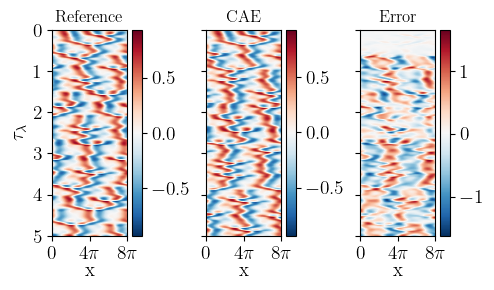

In [14]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/(ks_data["dt"]*ks_data["upsample"]))
N_plot = 5*N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length
domain_length = 20 * np.pi

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

N_start = 200 
reservoir, prediction = my_ESN.closed_loop_with_washout(u_encoded_test[N_start:N_start+N_washout, :dim], 15000)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+15000, :dim]).float().to(device)).numpy(force=True)


# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"]*ks_data["upsample"]))
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=fs)

axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
# plt.savefig("../images/cae-esn.png", dpi=100)
